In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from interpretability_utils import *

## Model

In [14]:
data=pd.read_csv("dataproject2022.csv", sep=';', index_col="ID",  decimal=',')
data= data.drop(['Pred_default (y_hat)', 'PD','Group'] , axis = 1)
train, test = train_test_split(data, test_size=0.2)



X_train = train.drop('Default (y)', axis=1)
y_train = train['Default (y)']
X_test = test.drop('Default (y)', axis=1)
y_test = test['Default (y)']

rf_tuned = RandomForestClassifier(criterion="gini", max_depth=10, max_features='auto', min_samples_leaf=5, min_samples_split=5, n_estimators=100)
rf_tuned.fit(X_train, y_train)
predictions_tuned = rf_tuned.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(predictions_tuned, y_test))

Accuracy: 0.806


## Global surrogate

In [15]:
new_target = rf_tuned.predict(X_train)

surrogate_model = DecisionTreeClassifier(max_depth=4)
surrogate_model.fit(X_train, new_target)

DecisionTreeClassifier(max_depth=4)

[Text(509.89655172413796, 978.48, 'Age <= 21.5\ngini = 0.101\nsamples = 5952\nvalue = [5633, 319]'),
 Text(211.6551724137931, 761.0400000000001, 'Funding amount <= 10802.5\ngini = 0.499\nsamples = 245\nvalue = [118, 127]'),
 Text(76.96551724137932, 543.6, 'Funding amount <= 6686.5\ngini = 0.349\nsamples = 102\nvalue = [79, 23]'),
 Text(38.48275862068966, 326.1600000000001, 'gini = 0.0\nsamples = 39\nvalue = [39, 0]'),
 Text(115.44827586206898, 326.1600000000001, 'Car price <= 10095.0\ngini = 0.464\nsamples = 63\nvalue = [40, 23]'),
 Text(76.96551724137932, 108.72000000000003, 'gini = 0.5\nsamples = 46\nvalue = [23, 23]'),
 Text(153.93103448275863, 108.72000000000003, 'gini = 0.0\nsamples = 17\nvalue = [17, 0]'),
 Text(346.3448275862069, 543.6, 'Loan duration <= 54.0\ngini = 0.397\nsamples = 143\nvalue = [39, 104]'),
 Text(269.3793103448276, 326.1600000000001, 'Age <= 20.5\ngini = 0.434\nsamples = 22\nvalue = [15, 7]'),
 Text(230.89655172413796, 108.72000000000003, 'gini = 0.291\nsample

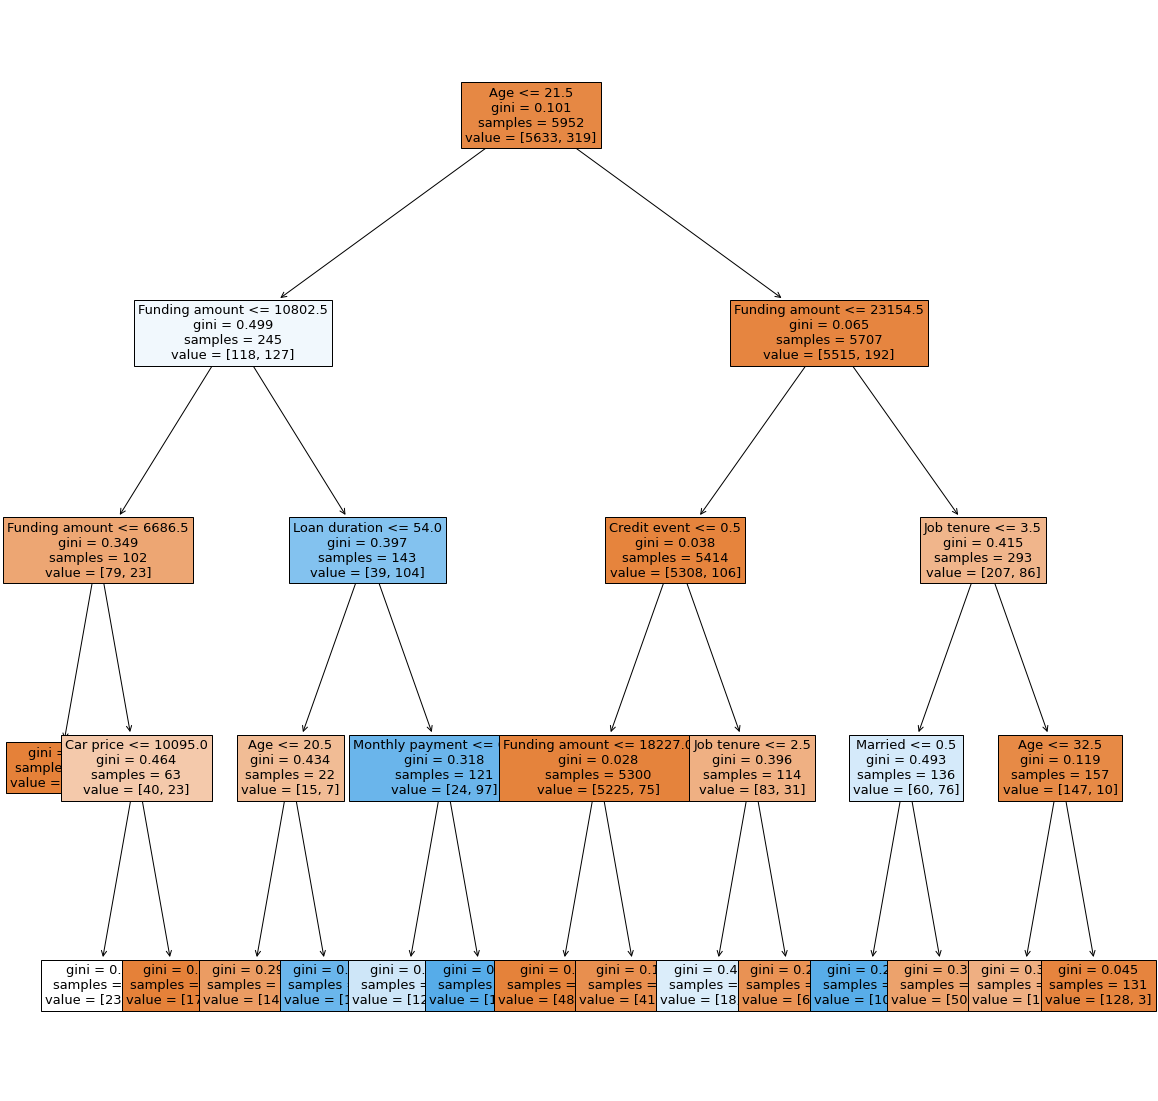

In [16]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(figsize=(20,20)) # Resize figure
tree.plot_tree(surrogate_model, filled=True, ax=ax, fontsize=13, feature_names=X_train.columns)
# plt.savefig('tree_high_dpi', dpi=100)

In [8]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = surrogate_model.feature_importances_
feature_importance.sort_values(by="importance", ascending=False)

px.bar(feature_importance, "importance","feature").update_xaxes(categoryorder='min ascending', title="Feature importance for decision tree classifier surrogate model on our blackbox model")

# Global Interpretability

### PDP 
The Partial Dependence Plot (PDP) shows the marginal effect one feature has on the predicted outcome of a machine learning model (Friedman 2001).

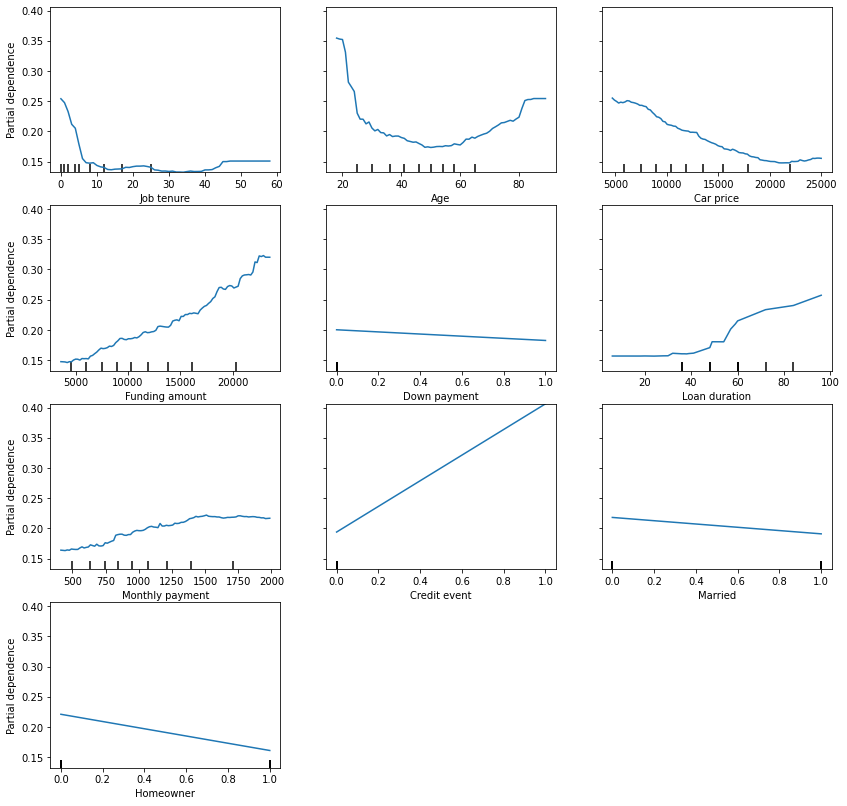

In [4]:
plot_pdp(X_train, rf_tuned)

#### Interpretation of the PDP : 
- Job tenure

### ICE

Individual Conditional Expectation (ICE) plots display one curve per instance 
    that shows how the instance’s prediction changes when a feature changes.

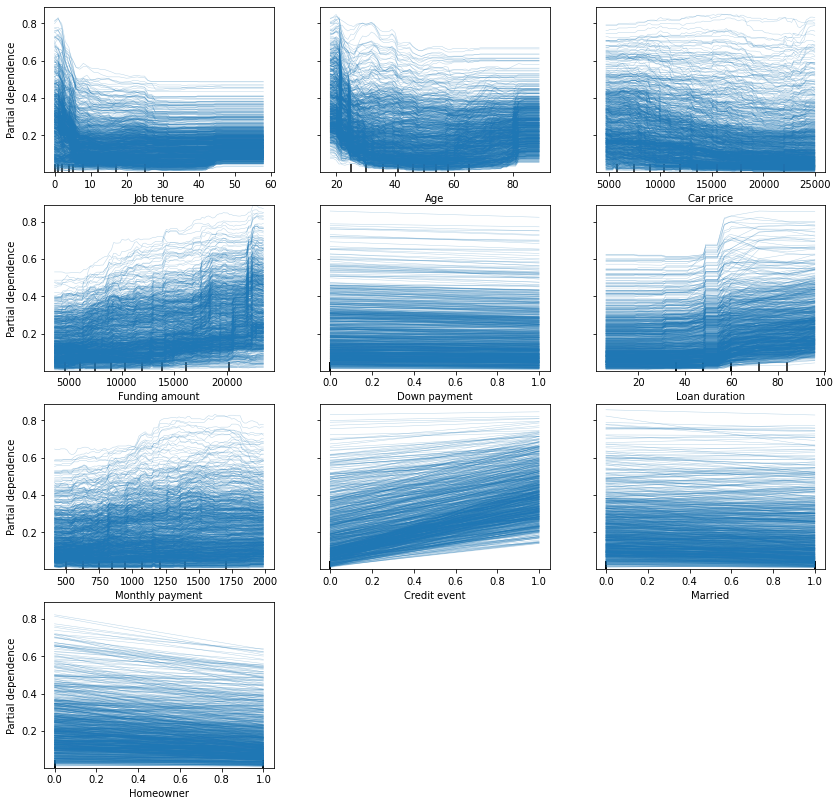

In [5]:
plot_ice(X_train, rf_tuned)

#### Interpretation of the ICE : 
- Job tenure... 

### ALE

Accumulated Local Effects (ALE) plots describe how features influence 
    the prediction of a ML model on average, while taking into account the 
    dependence between the features.

ALE solves the combined-effect problem by calculating differences in predictions instead
of averages, yet using conditional distributions.

PyALE._ALE_generic:INFO: Continuous feature detected.


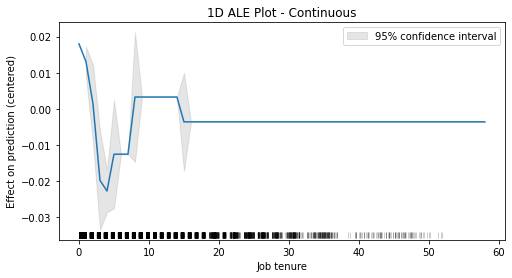

PyALE._ALE_generic:INFO: Continuous feature detected.


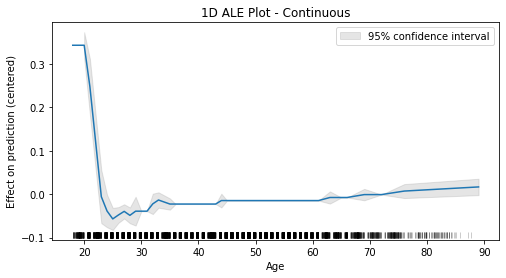

PyALE._ALE_generic:INFO: Continuous feature detected.


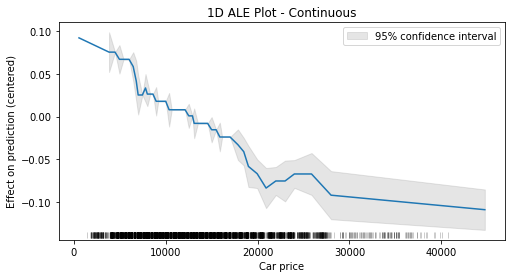

PyALE._ALE_generic:INFO: Continuous feature detected.


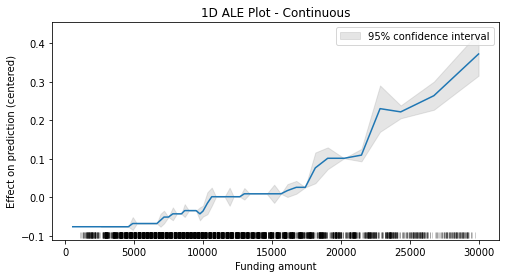

PyALE._ALE_generic:INFO: Discrete feature detected.


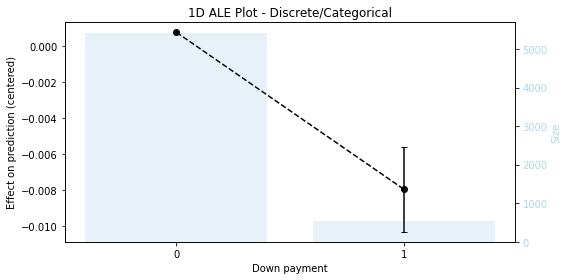

PyALE._ALE_generic:INFO: Continuous feature detected.


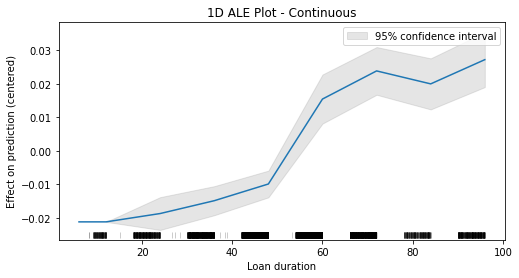

PyALE._ALE_generic:INFO: Continuous feature detected.


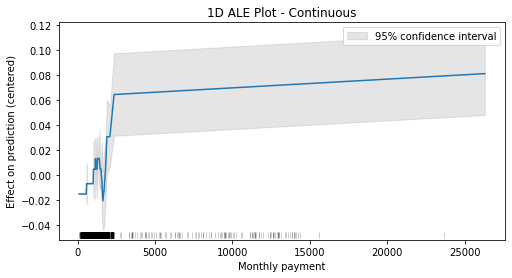

PyALE._ALE_generic:INFO: Discrete feature detected.


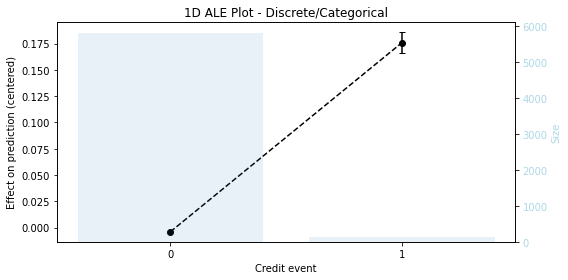

PyALE._ALE_generic:INFO: Discrete feature detected.


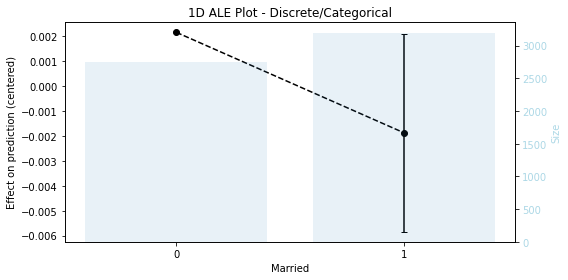

PyALE._ALE_generic:INFO: Discrete feature detected.


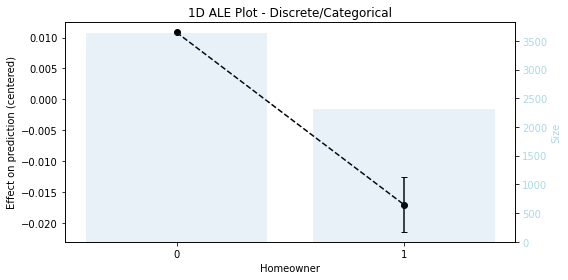

In [6]:
plot_ale(X_train, rf_tuned)

#### Interpretation of the ALE : 
- Job tenure... 

## Local interpretability

### LIME 

LIME explains the prediction of any model by learning from an interpretable model locally around the prediction.

In [14]:
display_lime(X_train, rf_tuned, X_train.index[0] )

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


#### Interpretation of LIME : 

### SHAP

The Shapley value of the feature xj is 
    the weighted average contribution of xj across all possible subsets S, 
    where S does not include xj.

In [21]:
explainer = shap.TreeExplainer(rf_tuned)
choosen_instance = X_train.loc[1, :]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)


#### Interpretation of shap : 